In [1]:
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns

import helpers

### Data loading

In [2]:
attribute_name = "katz"
attributes = helpers.load_attributes(attribute_name)

variables = ["groenwold", "blodgett", "race"]
variable2type = {
    "blodgett": "covert",
    "groenwold": "covert",
    "race": "overt"
}

stereotype_types = ["overt", "covert"]

model2ppl_type = {
    "gpt2": "Perplexity",
    "gpt3": "Perplexity",
    "t5": "Pseudo-perplexity",
    "roberta": "Pseudo-perplexity"
}

In [3]:
stereotype_results = pd.DataFrame()
for variable in variables:
    for model in helpers.MODELS:
        if model == "gpt4":
            continue
        results = helpers.load_results(
            model, 
            variable, 
            attribute_name
        )
        results_df = helpers.results2df(
            results, 
            attributes, 
            model,
            variable
        )
        results_df["type"] = variable2type[variable]
        stereotype_results = pd.concat([
            stereotype_results, 
            results_df, 
        ])

### Analysis

In [4]:
k = 5
attribute2score = helpers.load_ratings("katz")
stereo_attributes = helpers.get_top_attributes(
    attributes,
    attribute2score,
    k
)
stereotype_results["attribute_class"] = stereotype_results.attribute.apply(
    lambda x: helpers.attribute2class(x, stereo_attributes)
)

strength_list = []
for model in helpers.PRETTY_MODELS:
    if model == "GPT4":
        continue
    for stereotype_type in stereotype_types:
        results_model = stereotype_results[
            (stereotype_results.model==model) & 
            (stereotype_results.type==stereotype_type)
        ]
        model_prompts = set(results_model.prompt)
        model_variables = set(results_model.variable)
        for prompt in model_prompts:
            for variable in model_variables:
                dif = helpers.get_dif(
                    results_model[
                        (results_model.prompt==prompt) & 
                        (results_model.variable==variable) & 
                        (results_model.attribute_class=="general")
                    ], 
                    results_model[
                        (results_model.prompt==prompt) & 
                        (results_model.variable==variable) &
                        (results_model.attribute_class=="stereo")
                    ] 
                )
                strength_list.append((
                    dif,
                    model,
                    stereotype_type,
                    variable,
                    prompt
                ))

strength_results = pd.DataFrame(
    strength_list,
    columns=["strength", "model", "type", "variable", "prompt"]
)
strength_results["family"] = strength_results.model.apply(
    lambda x: helpers.pretty_model2family(x)
)
strength_results["size"] = strength_results["model"].apply(
    lambda x: helpers.model2size(x)
)
strength_results["model_size"] = strength_results["model"].apply(
    lambda x: helpers.model2model_size(x)
)
strength_results["size_class"] = strength_results["model_size"].apply(
    lambda x: helpers.size2class(x)
)

In [5]:
for model in helpers.PRETTY_MODELS:
    if model == "GPT4":
        continue
    results_model_covert = strength_results[
        (strength_results.model==model) &
        (strength_results.type=="covert")
    ]
    results_model_overt = strength_results[
        (strength_results.model==model) &
        (strength_results.type=="overt")
    ]
    mean_covert = results_model_covert.strength.mean()
    std_covert = results_model_covert.strength.std()
    mean_overt = results_model_overt.strength.mean()
    std_overt = results_model_overt.strength.std()
    print(f"{model}, {mean_covert:.3f}, {std_covert:.3f}, {mean_overt:.3f}, {std_overt:.3f}")

GPT2 (base), 0.087, 0.029, 0.044, 0.083
GPT2 (medium), 0.090, 0.029, -0.040, 0.118
GPT2 (large), 0.105, 0.028, -0.006, 0.088
GPT2 (xl), 0.089, 0.044, 0.041, 0.119
RoBERTa (base), 0.118, 0.027, -0.058, 0.094
RoBERTa (large), 0.166, 0.045, -0.090, 0.100
T5 (small), 0.005, 0.031, 0.088, 0.049
T5 (base), 0.074, 0.037, -0.002, 0.060
T5 (large), 0.073, 0.033, -0.011, 0.109
T5 (3b), 0.113, 0.028, -0.091, 0.117
GPT3.5, 0.187, 0.116, -0.119, 0.248


In [6]:
perplexity_list = []
for variable in variables:
    if variable == "race":
        continue
    for model in helpers.MODELS:
        if model == "gpt4":
            continue
        ppls = helpers.load_ppls(model, variable)
        for i in range(len(ppls["aave"])):
            perplexity_list.append((
                ppls["aave"][i],
                ppls["sae"][i],
                model,
                variable
            ))

perplexity_results = pd.DataFrame(
    perplexity_list,
    columns=["ppl_aae", "ppl_sae", "model", "variable"]
)
perplexity_results["family"] = perplexity_results["model"].apply(
    lambda x: helpers.model2family(x)
)
perplexity_results["size"] = perplexity_results["model"].apply(
    lambda x: helpers.model2size(x)
)
perplexity_results["model"] = perplexity_results.apply(
    lambda r: helpers.pretty_model(r["family"], r["size"]), 
    axis=1
)
perplexity_results["model_size"] = perplexity_results["model"].apply(
    lambda x: helpers.model2model_size(x)
)
perplexity_results["size_class"] = perplexity_results["model_size"].apply(
    lambda x: helpers.size2class(x)
)
perplexity_results["ppl_type"] = perplexity_results["family"].apply(
    lambda x: model2ppl_type[x]
)
perplexity_results["type"] = "ppl"

In [7]:
for model in helpers.PRETTY_MODELS:
    if model == "GPT4":
        continue
    perplexity_model = perplexity_results[
        perplexity_results.model==model
    ]
    aave_ppl_model = perplexity_model.ppl_aae.mean()
    aave_std_model = perplexity_model.ppl_aae.std()
    sae_ppl_model = perplexity_model.ppl_sae.mean()
    sae_std_model = perplexity_model.ppl_sae.std()
    print(
        model, 
        "{:.1f}".format(aave_ppl_model), 
        "{:.1f}".format(aave_std_model), 
        "{:.1f}".format(sae_ppl_model), 
        "{:.1f}".format(sae_std_model)
    )

GPT2 (base) 460.0 834.4 140.9 158.8
GPT2 (medium) 353.3 421.7 112.8 137.6
GPT2 (large) 310.7 368.3 100.0 115.2
GPT2 (xl) 296.3 367.3 95.7 114.8
RoBERTa (base) 80.4 160.6 16.9 36.3
RoBERTa (large) 44.8 88.6 12.3 28.7
T5 (small) 89.3 106.8 31.9 38.4
T5 (base) 42.0 54.6 15.5 19.9
T5 (large) 27.9 35.0 11.3 13.9
T5 (3b) 20.9 25.8 10.0 12.5
GPT3.5 267.5 342.9 143.0 480.1


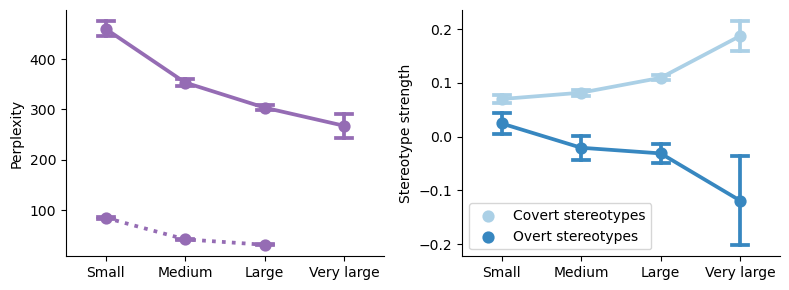

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

g = sns.pointplot(
    data=strength_results, 
    x="size_class", 
    y="strength", 
    hue="type",
    hue_order=["covert", "overt"],
    capsize=0.2, 
    palette="Blues", 
    errorbar="se",
    ax=axes[1],
    order=["small", "medium", "large", "xl"],
)

axes[1].spines[["right", "top"]].set_visible(False)
axes[1].set_xlabel("")
axes[1].set_ylabel("Stereotype strength")
axes[1].set_xticklabels(["Small", "Medium", "Large", "Very large"])
handles, _ = axes[1].get_legend_handles_labels()
axes[1].legend(
    handles, ["Covert stereotypes", "Overt stereotypes"], loc="lower left", ncols=1)

g = sns.pointplot(
    data=perplexity_results[perplexity_results.ppl_type=="Perplexity"], 
    x="size_class", 
    y="ppl_aae", 
    hue="type",
    capsize=0.2, 
    palette=[sns.color_palette("muted")[4]], 
    errorbar="se",
    ax=axes[0],
    order=["small", "medium", "large", "xl"]
)

g = sns.pointplot(
    data=perplexity_results[perplexity_results.ppl_type!="Perplexity"], 
    x="size_class", 
    y="ppl_aae", 
    hue="type",
    linestyles=":",
    capsize=0.2, 
    palette=[sns.color_palette("muted")[4]], 
    errorbar="se",
    ax=axes[0],
    order=["small", "medium", "large", "xl"]
)

axes[0].spines[["right", "top"]].set_visible(False)
axes[0].set_xlabel("")
axes[0].set_ylabel("Perplexity")
axes[0].set_xticklabels(["Small", "Medium", "Large", "Very large"])
axes[0].get_legend().remove()

plt.tight_layout()
plt.show()